<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />

# Implementado redes recurrentes simples<a id="top"></a>

<i><small>Last update: 2024-03-07</small></i></div>
***

## Introducción

Las redes neuronales recurrentes (RNN, del inglés _recurrent neural networks_) son un tipo de red neuronal que se utiliza para procesar datos secuenciales. A diferencia de las redes neuronales tradicionales, las RNN tienen conexiones entre los nodos que permiten que la información pase de un paso al siguiente. Esto las hace especialmente útiles para procesar datos que tienen una estructura temporal o secuencial, como las series temporales, el habla y el texto.

La idea básica de las RNN es utilizar la salida del paso anterior como entrada para el paso actual. Esto crea un bucle de retroalimentación que permite a la red mantener información sobre la secuencia que ha procesado hasta el momento. En su forma más simple, se implementan mediante unidades recurrentes simples (SRU). Las SRU son a las RNN lo que las neuronas son a las redes neuronales tradicionales. La única diferencia es que la salida de la red se concatena con la entrada, de modo que la salida anterior forma parte de la entrada actual.

## Objetivos

En este _notebook_ vamos a implementar una red neuronal recurrente para resolver el problema [`mnist`](http://yann.lecun.com/exdb/mnist/). En realidad lo haremos más como un ejercicio que como un problema de aplicación real, ya que técnicamente el `mnist` es un problema de reconocimiento de imágenes. Sin embargo, como veremos, las RNNs, leyendo las filas de arriba a abajo de la imagen de los números son capaces de conseguir resultados comparables a los de las Redes de Convolución (CNNs).

Al final habremos aprendido a:

- Crear y entrenar un modelo recurrente para resolver problemas de clasificación utilizando, para ello, una SRU.
- Apilar dos o más SRUs para hacer Redes Recurrentes multicapa, aumentando así la potencia de estas redes.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

2023-05-16 17:14:51.034636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 17:14:51.233384: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-16 17:14:51.233402: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-16 17:14:52.160956: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
%matplotlib inline
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})
plt.style.use('ggplot')

***

## Descarga y preprocesamiento de datos

Comenzamos como en el resto de _notebooks_, descargando y preparando el conjunto `mnist` para nuestra tarea.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255

print(f'Training shape: {x_train.shape} input, {y_train.shape} output')
print(f'Test shape:     {x_test.shape} input, {y_test.shape} output')

Training shape: (60000, 28, 28) input, (60000,) output
Test shape:     (10000, 28, 28) input, (10000,) output


## Modelo basado en una capa de SRU

La primera capa será una SRU (implementada en keras como `layers.SimpleRNN`) de 10 «unidades» (una salida de dimensión 10) y cuya entrada son las dimensiones de la imagen (es decir, $28 \times 28$).

La segunda capa será una densa con activación softmax para las 10 posibles salidas. Esto significa que los 10 valores de salida de nuestra `SimpleRNN` se conectarán a 10 neuronas de nuestra capa `Dense` para un total de $10 \cdot 10 + 10$ conexiones.

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(units=10, input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                390       
                                                                 
 dense (Dense)               (None, 10)                110       
                                                                 
Total params: 500
Trainable params: 500
Non-trainable params: 0
_________________________________________________________________


2023-05-16 17:17:44.408406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-16 17:17:44.408434: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-16 17:17:44.408455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bulma): /proc/driver/nvidia/version does not exist
2023-05-16 17:17:44.408719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Aunque estamos indicando una entrada de $28 \times $28 no estamos ofreciendo una entrada de 28 filas por 28 columnas; estamos ofreciendo una entrada de 28 elementos de una secuencia, cada uno de tamaño 28. Es decir, nuestra red va a recibir primero la primera fila de la imagen, luego la segunda, luego la tercera, y así sucesivamente hasta la fila número 28.

Por último, vamos a compilar el modelo creado con la función de pérdida que corresponde a este tipo de problema con un optimizador de descenso de gradiente estocástico y vamos a añadir la métrica _exaccuracy_ para ver cómo evoluciona este entrenamiento.

In [5]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'],
)

### Entrenamiento del modelo

Por último, entrenaremos nuestra red durante 25$ epochs. Cuidado con el tiempo de entrenamiento, ya que en el caso de las redes recurrentes es bastante lento.

In [6]:
history = model.fit(x_train, y_train, epochs=25)

Epoch 1/25
1875/1875 [==============================] - 12s 6ms/step - loss: 1.4451 - sparse_categorical_accuracy: 0.5109
Epoch 2/25
1875/1875 [==============================] - 9s 5ms/step - loss: 1.0692 - sparse_categorical_accuracy: 0.6390
Epoch 3/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9734 - sparse_categorical_accuracy: 0.6719
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.9127 - sparse_categorical_accuracy: 0.6938
Epoch 5/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8681 - sparse_categorical_accuracy: 0.7121
Epoch 6/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8376 - sparse_categorical_accuracy: 0.7226
Epoch 7/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8146 - sparse_categorical_accuracy: 0.7313
Epoch 8/25
1875/1875 [==============================] - 12s 6ms/step - loss: 0.7935 - sparse_categorical_accuracy: 0.7386
Epoch 9/25
1875/1875 [========

Veamos cómo ha evolucionado la formación.

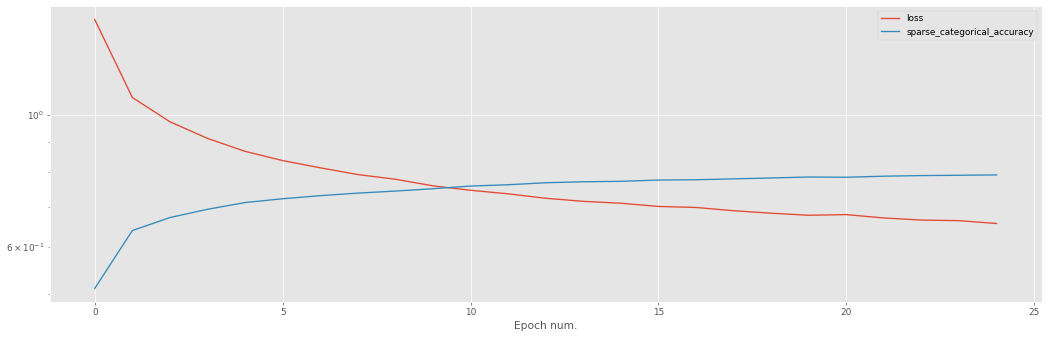

In [7]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Podemos ver que están lejos de las precisiones conseguidas con otras técnicas de aprendizaje profundo, especialmente si las comparamos con las redes convolucionales. Pero como hemos dicho, se trata de un ejemplo de implementación, no de un caso de uso concreto.

### Clasificación de dígitos

Vamos a hacer algunas inferencias sobre el conjunto de datos de prueba. Veremos que nuestro modelo falla significativamente más que en otros casos.

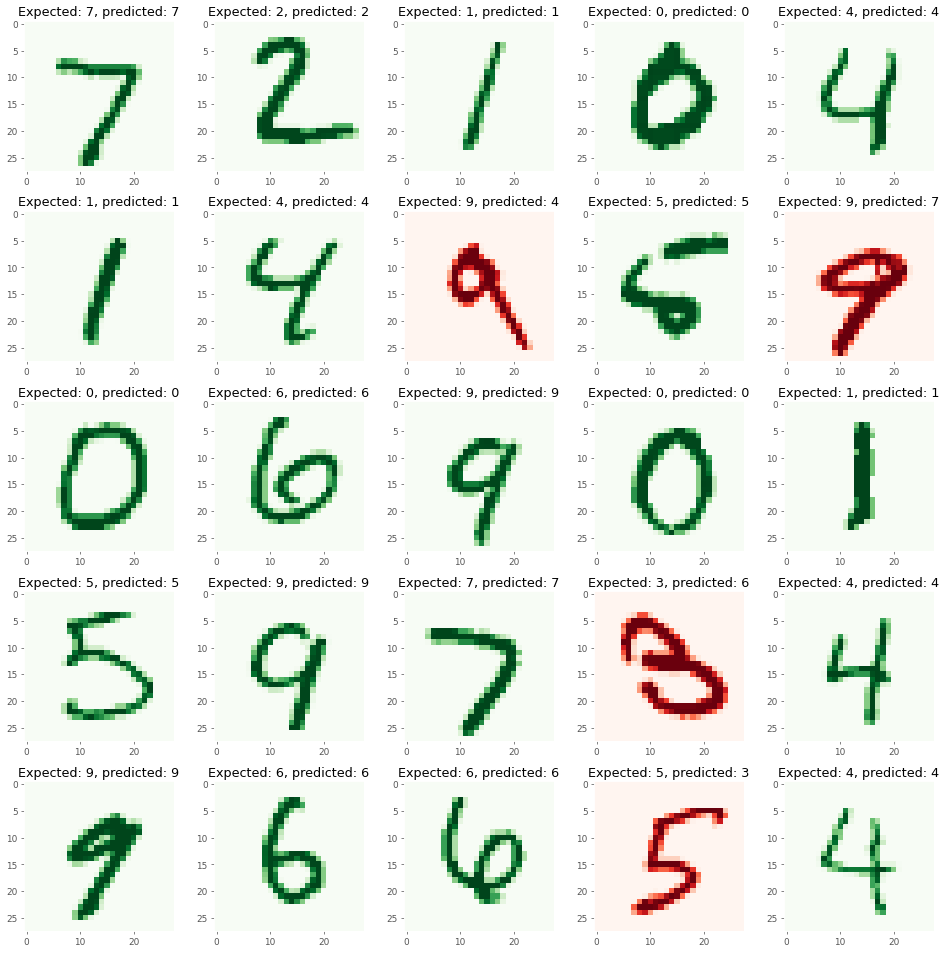

In [8]:
# Predict some of the test digits
ROWS, COLS = 5, 5
IMAGES = ROWS * COLS
ŷ_test = np.argmax(model.predict(x_test[:IMAGES], verbose=0), axis=1)
# And plot them
fig = plt.figure(figsize=(15, 15))
for i, (x, y, ŷ) in enumerate(zip(x_test[:IMAGES], y_test[:IMAGES], ŷ_test), 1):
    ax = fig.add_subplot(ROWS, COLS, i)
    ax.imshow(x, cmap='Greens' if y == ŷ else 'Reds')
    ax.set_title(f'Expected: {y}, predicted: {ŷ}')
    ax.grid(False)
plt.tight_layout()

## Conclusiones

Hemos aprendido a implementar una RNN simple en Keras, construyendo un modelo sencillo para clasificar las imágenes `mnist` en sus correspondientes etiquetas, demostrando cómo compilar y entrenar el modelo, y cómo evaluar su rendimiento utilizando la exactitud (_accuracy_) como métrica. En realidad, hemos hecho lo que hasta ahora, pero con redes recurrentes, y hemos visto que es prácticamente igual.

Pero al menos hemos aprendido que se puede hacer y que es fácil. Est _notebook_ nos sirve como punto de partida para implementar modelos RNN más complejos en Keras para tareas como la predicción de series temporales o el procesamiento del lenguaje natural.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Back to top](#top)

</div>